In [3]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [4]:
def visualise_lines(lines,line_image,original_image):
    for line in lines:
        for x1,y1,x2,y2 in line:
            x=[x1,x2]
            y=[y1,y2]
            # Calculate the coefficients. This line answers the initial question. 
            # coefficients = np.polyfit(x, y, 1)
            # coefficientsInv = np.polyfit(y, x, 1)
            # polynomial = np.poly1d(coefficients)
            # polynomialInv = np.poly1d(coefficientsInv)
            dy=y2-y1
            dx=x2-x1
            angle=math.atan2(dy,dx)
            angle=math.degrees(angle)

            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    plt.subplot(121)
    plt.imshow(line_image,cmap="gray")
    plt.subplot(122)
    plt.imshow(original_image,cmap="gray")

/home/marios/catkin_ws/src/thesis_drone/src/Drone_Pose_Estimation/CV_techniques
/usr/lib/python3/dist-packages/cv2.cpython-38-x86_64-linux-gnu.so


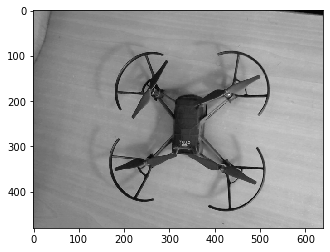

In [5]:
print(os.getcwd())
print(cv2.__file__)
photo_id=2
test_path='/home/marios/catkin_ws/src/thesis_drone/src/Drone_Pose_Estimation/test_photos/CV_%d.jpg'%( photo_id )
img = cv2.imread(test_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

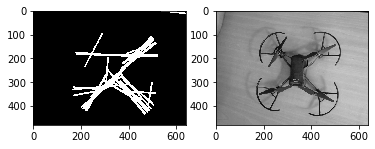

In [6]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray,threshold1=250/3,threshold2=250)
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 120  # minimum number of pixels making up a line
# min_line_length = 80  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image = np.ones((gray.shape[0],gray.shape[1]) )  # creating a blank to draw lines on
# plt.figure()
# plt.imshow(edges)
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
visualise_lines(lines,line_image,gray)

In [7]:
def resize_image(img,factor):
    # print('Original Dimensions : ', img.shape)
    width  = int(img.shape[1] * factor)
    height = int(img.shape[0] * factor)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    # print('Resized Dimensions : ',resized.shape)
    return resized

img.shape: (480, 640)


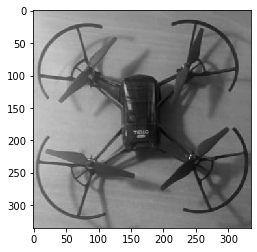

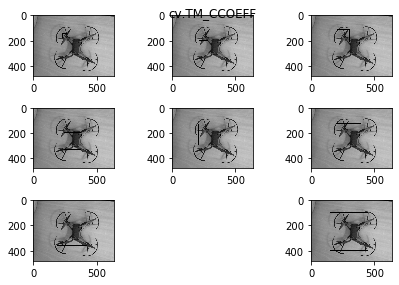

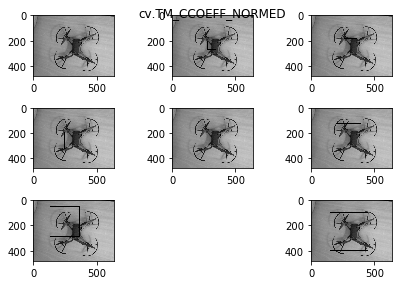

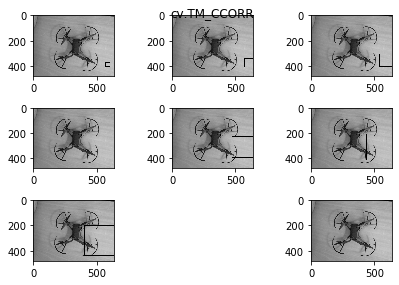

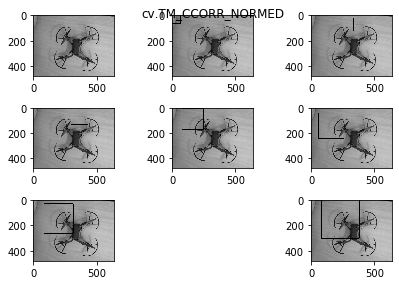

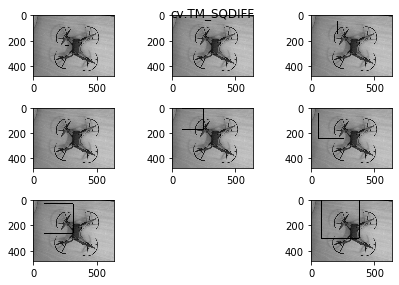

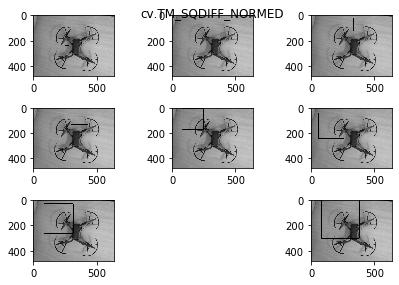

In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

img = cv.imread(test_path)
img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img=rotate_image(img,0)
print("img.shape:",img.shape)

img2 = img.copy()
template = cv.imread('/home/marios/catkin_ws/src/thesis_drone/src/Drone_Pose_Estimation/test_photos/CV_2_template.jpg')
template= cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)

plt.imshow(template,cmap="gray")
plt.show()

# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
factors=[ i/10 for i in list ( range(1,10,1) ) ]

for meth in methods:
    method = eval(meth)
    for i,f in enumerate(factors):
        img = img2.copy()
        resized_template=resize_image(template,f)
        w, h = resized_template.shape[::-1]
        # Apply template Matching
        res = cv.matchTemplate(img,resized_template,method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        
        # print("top_left:",top_left)
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv.rectangle(img,top_left, bottom_right, 0, 2)
        plt.subplot(3,len(factors)/3,i+1),plt.imshow(img,cmap = 'gray')
        # plt.title('Scale factor:%.1f'%(f)), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)
        plt.tight_layout()
    plt.show()

In [9]:
def explore_match(win, img1, img2, kp1, kp2, good, status = None, H = None):
    # draw homography and lines between matches
    h1, w1 = img1.shape[:2]
    matchesMask = status.ravel().tolist()
    pts = np.float32([[0, 0], [0, h1-1], [w1-1, h1-1], [w1-1, 0]]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,H)
    img2new = cv.polylines(img2, [np.int32(dst)], True,0,3, cv.LINE_AA)
    draw_params = dict(matchColor = (255,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    plt.imshow(img2new,cmap="gray")
    plt.show()
    img3 = cv.drawMatches(img1,kp1,img2new,kp2,good,None,**draw_params)
    return img3

In [10]:
def filter_matches(kp1, kp2, matches, ratio = 0.8):
    # ratio test
    mkp1, mkp2, good= [], [], []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
            good.append(m)
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, kp_pairs, good

14 / 42  inliers/matched


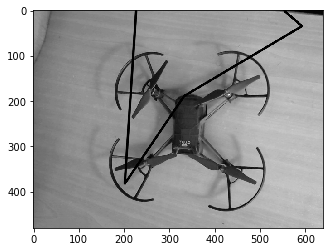

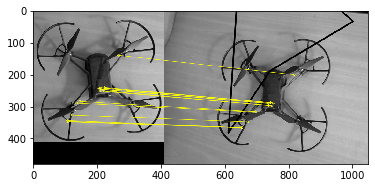

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
template_path='/home/marios/catkin_ws/src/thesis_drone/src/Drone_Pose_Estimation/test_photos/CV_3.jpg'
test_path='/home/marios/catkin_ws/src/thesis_drone/src/Drone_Pose_Estimation/test_photos/CV_2.jpg'


# path of image 1
path1 = template_path

# path of image 2
path2 = test_path

img1 = cv.imread(path1) 
img1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

img2 = cv.imread(path2) 
img2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2=rotate_image(img2,0)

detector = cv.BRISK_create()
norm = cv.NORM_HAMMING
# finding features
kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)
result1 = cv.drawKeypoints(img1, kp1, None)
# cv.imwrite("features1.jpg", result1)
result2 = cv.drawKeypoints(img2, kp2, None)
# cv.imwrite("features2.jpg", result2)
# finding matches
FLANN_INDEX_LSH    = 6
flann_params= dict(algorithm = FLANN_INDEX_LSH,
                               table_number = 6, # 12
                               key_size = 7,     # 20
                               multi_probe_level = 1) #2
matcher = cv.FlannBasedMatcher(flann_params, {})
raw_matches = matcher.knnMatch(desc1, trainDescriptors = desc2, k = 2) 

# finding good matches
p1, p2, kp_pairs, good = filter_matches(kp1, kp2, raw_matches)
if len(p1) >= 4:
    H, status = cv.findHomography(p1, p2, cv.RANSAC, 5.0)
    print('%d / %d  inliers/matched' % (np.sum(status), len(status)))
else:
    H, status = None, None
    print('%d matches found, not enough for homography estimation' % len(p1))
vis = explore_match("win", img1, img2, kp1, kp2, good, status, H)
plt.imshow( vis)

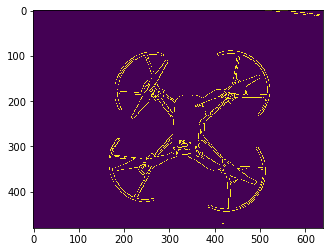

Number of Contours is: 86


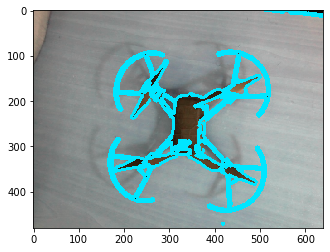

In [12]:
# Load an image
image = cv2.imread(test_path)
# Changing the colour-space
LUV = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
# Find edges
edges = cv2.Canny(LUV, 250/2, 250)
plt.imshow(edges)
plt.show()
# Find Contours
contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Find Number of contours
print("Number of Contours is: " + str(len(contours)))
# Draw yellow border around two contours
cv2.drawContours(image, contours, -1, (0, 230, 255), 6)
# Show the image with contours
plt.imshow( image)



import cv2

Background_subtract = cv2.bgsegm.createBackgroundSubtractorMOG()


#ret and frame, first and next frame
frame=cv2.imread(template_path)

#first_frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#Background_subtract.apply(frame)
first_frame = Background_subtract.apply(frame)

gblur = cv2.GaussianBlur(first_frame, (5, 5), 0)
plt.imshow(gblur)
plt.title("mlkia")


#contouring
#threshold : Separate out regions of an image corresponding to objects which we want to analyze.
ret, threshold = cv2.threshold(gblur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours,_ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# print(contours)
print("number of contours detected", len(contours))
cv2.drawContours(frame, contours, 0, (0, 0, 255), 6)

plt.imshow( frame)
plt.show()
plt.imshow( gblur,cmap="gray")



# Python code for Background subtraction using OpenCV
import numpy as np
import cv2
 
cap = cv2.VideoCapture(0)
# fgbg = cv2.createBackgroundSubtractorMOG2()
fgbg = cv2.createBackgroundSubtractorMOG2(history = 500, varThreshold = 16, detectShadows =False)

while(1):
    ret, frame = cap.read()
 
    fgmask = fgbg.apply(frame)
  
    cv2.imshow('fgmask', fgmask)
    cv2.imshow('frame',frame )
 

     
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
     
 
cap.release()
cv2.destroyAllWindows()